# Run an EDA on our dataset in ../data

In [3]:
# Imports + Config
import os, random
from collections import Counter
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# set data path
DATA_DIR = "../data"
SAMPLE_PER_CLASS = 4
VALID_EXTS = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff', '.jfif')


In [4]:
# Count images per pixel class
class_counts = {}

for cls in sorted(os.listdir(DATA_DIR)):
    cls_path = os.path.join(DATA_DIR, cls)
    if os.path.isdir(cls_path):
        count = len([f for f in os.listdir(cls_path) if f.lower().endswith(VALID_EXTS)])
        class_counts[cls] = count

print("Image counts per class:")
for k, v in class_counts.items():
    print(f"{k:45s} : {v}")


Image counts per class:
1. Eczema                                     : 751
10. Warts Molluscum and other Viral Infections : 931
2. Melanoma                                   : 938
3. Atopic Dermatitis                          : 563
4. Basal Cell Carcinoma                       : 993
5. Melanocytic Nevi                           : 2381
6. Benign Keratosis-like Lesions              : 931
7. Psoriasis pictures Lichen Planus and related diseases : 921
8. Seborrheic Keratoses and other Benign Tumors : 828
9. Tinea Ringworm Candidiasis and other Fungal Infections : 763


/var/folders/6_/3_rwpm0s3rn04_rq560zzkz00000gn/T/ipykernel_5167/975257151.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="crest")


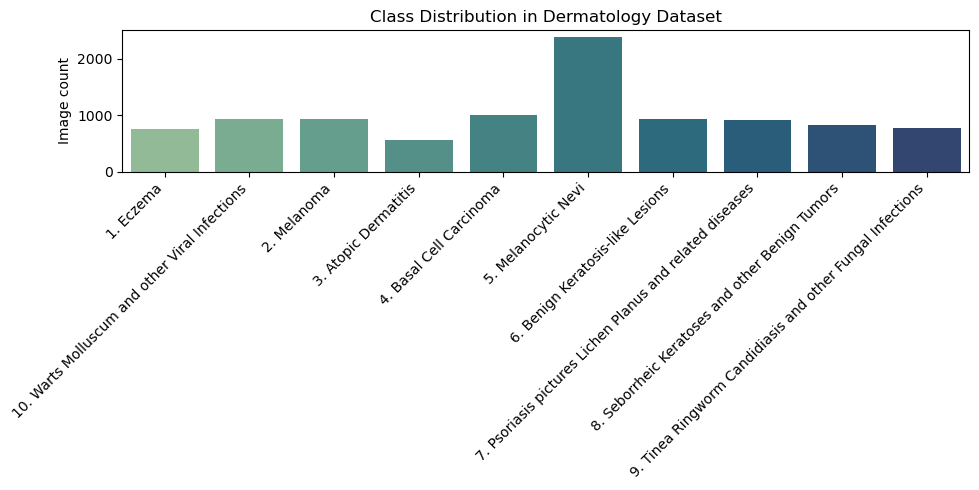

In [5]:
# Bar Chart
plt.figure(figsize=(10,5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="crest")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Image count")
plt.title("Class Distribution in Dermatology Dataset")
plt.tight_layout()
plt.show()


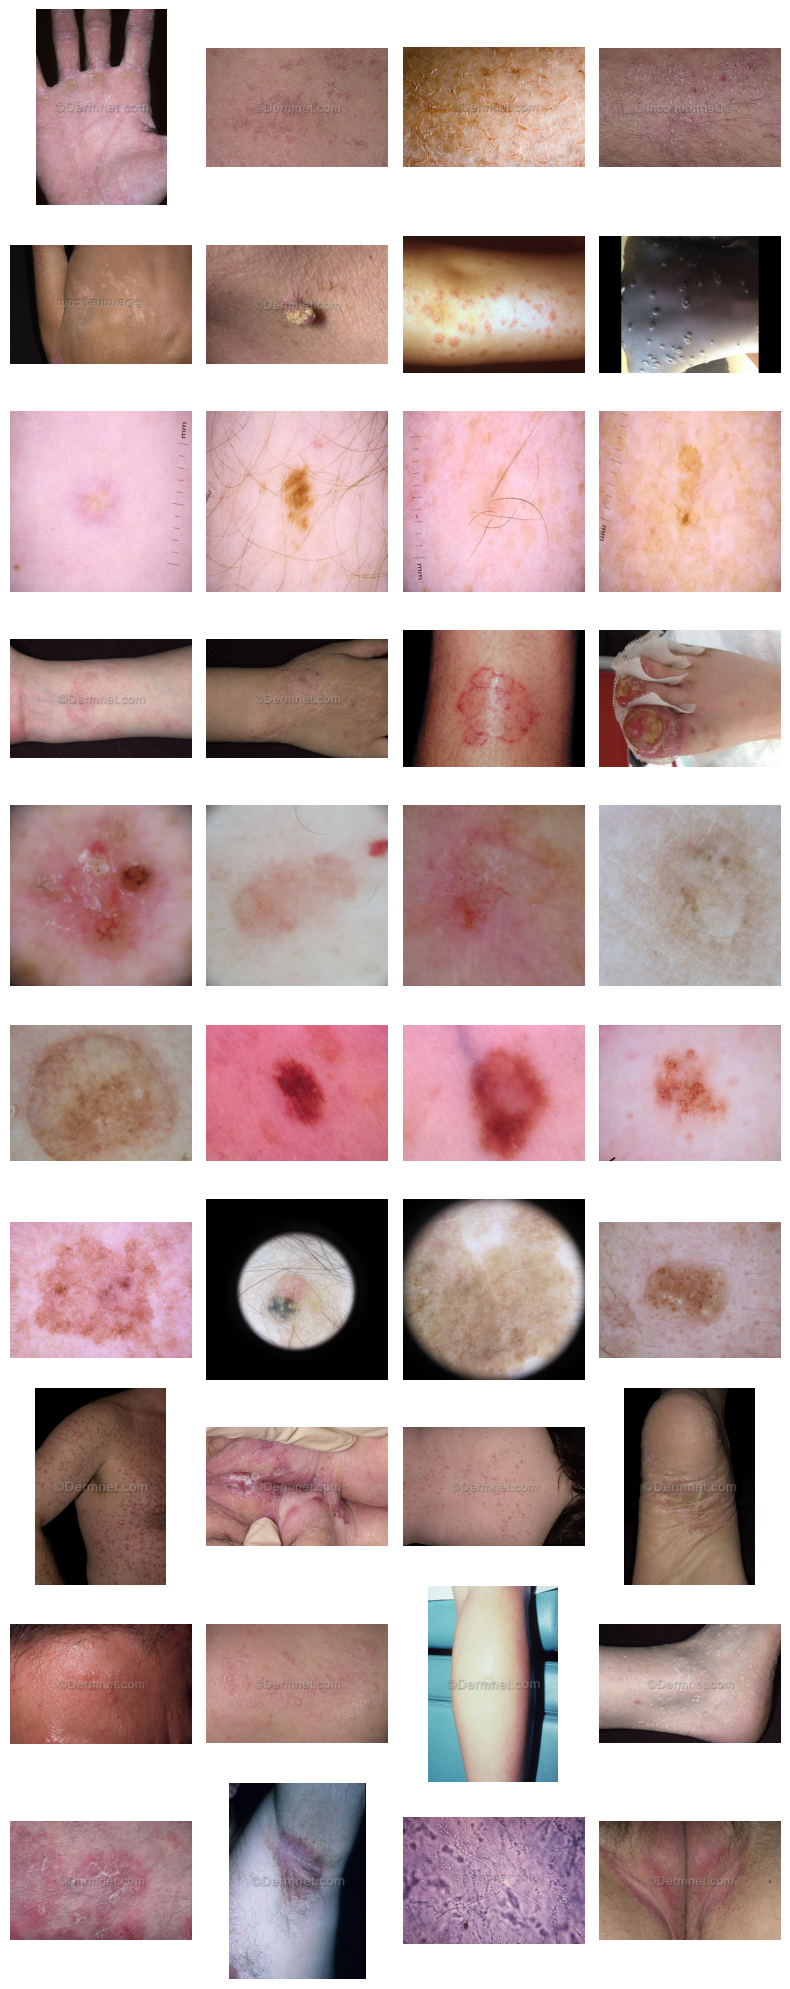

In [6]:
# Random Sample Visualization
fig, axes = plt.subplots(len(class_counts), SAMPLE_PER_CLASS, figsize=(SAMPLE_PER_CLASS*2, len(class_counts)*2))

for i, cls in enumerate(sorted(class_counts.keys())):
    cls_path = os.path.join(DATA_DIR, cls)
    imgs = [f for f in os.listdir(cls_path) if f.lower().endswith(VALID_EXTS)]
    random_imgs = random.sample(imgs, min(SAMPLE_PER_CLASS, len(imgs)))
    for j, img_name in enumerate(random_imgs):
        img_path = os.path.join(cls_path, img_name)
        img = Image.open(img_path).convert("RGB")
        axes[i, j].imshow(img)
        axes[i, j].axis("off")
        if j == 0:
            axes[i, j].set_ylabel(cls, fontsize=8)
plt.tight_layout()
plt.show()


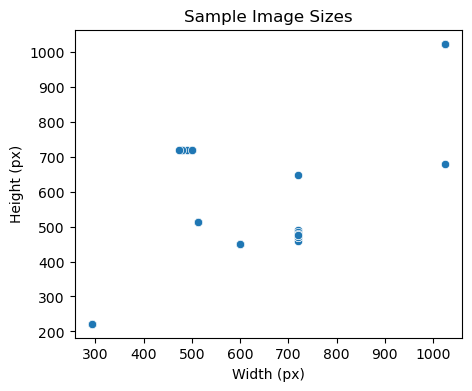

Average width:  647.1px
Average height: 570.3px


In [7]:
# Average image sizes
sizes = []
for cls in class_counts.keys():
    cls_path = os.path.join(DATA_DIR, cls)
    imgs = [f for f in os.listdir(cls_path) if f.lower().endswith(VALID_EXTS)]
    for img_name in random.sample(imgs, min(5, len(imgs))):
        with Image.open(os.path.join(cls_path, img_name)) as im:
            sizes.append(im.size)

widths, heights = zip(*sizes)
plt.figure(figsize=(5,4))
sns.scatterplot(x=widths, y=heights)
plt.title("Sample Image Sizes")
plt.xlabel("Width (px)")
plt.ylabel("Height (px)")
plt.show()

print(f"Average width:  {sum(widths)/len(widths):.1f}px")
print(f"Average height: {sum(heights)/len(heights):.1f}px")


# Conclusions

## Image Sizes

- Average ~ 647 x 570 px
- Range from ~ 300 x 200 up to ~1000 x 1000 px

Conclusion
- The dataset has moderate variability in image dimensions, so resizing all images to a fixed (x, y) has no severe distortion risk. We may add a small RandomResizedCrop(120) during training for robustness to scale and position


## Class Distribution

- Strong imbalance: Melanocytic Nevi dominates (~2300 images) while others (such as Eczema) have fewer than 800.

Conclusion
- Use class weights in the loss function (or a WeightedRandomSampler) to prevent bias toward the dominant classes


## Visual Variety

- Different scales: Some classes are close-up (dermoscopic/microscope; circular vignettes, zoomed lesions, uniform lighting) while others show full-body patches (clinical/macro photographs; entire body parts, variable skin tone, lighting, and background). The model must learn scale-invariant features. Risk: Model could learn that dark-circle vignette --> microscope images --> certain diseases
- Fixes: RandomResizedCrop(scale=(0.6,1.0)) to simulate zoom variability. RandomAffine(degrees=10, translate=(0.05, 0.05)) to randomize lesion placement. RandomErasing(p=0.2) to simulate partial occlusion (removes over-reliance on context). ColorJitter(brightness=0.1, contrast=0.1) to handle lighting diversity.
- Different framing/backgrounds: Model may learn to classify based on background color/texture. Fixes: During preprocessing, crop out circular black boarders by thresholding near-black pixels, or use center-crop + RandomResizedCrop to reduce reliance on background.
- Source Artifacts (@Dermnet watermarks): Model could treat watermark text as class-specific features (spurious correlation). Fixes: Apply RandomResizedCrop and RandomAffine (to sometimes cut out watermark corners). Add a light GaussianBlur or RandomPerspective to distort text. If we wanted to, pre-process by blurring watermark text using OpenCV (cv2.inpaint).
- Lighting: Dermoscopic images are well-lit and uniform. Body shots vary in exposure and white balance. Standardize color distribution via normalization (ImageNet mean/std is fine). Use ColorJitter with low parameters to simulate exposure variation.
- Data Representatino Bias: Some classes exist only in one visual modality (microscopic only) while others appear in both. This means the model might overfit modality rather than lesion morphology. Fixes: Data-level: Apply stronger augmentations to classes that lack diversity (e.g., Atopic Dermatitis → zoom-in simulation; Melanoma → add macro crops). Model-level: If you later use CNN + attention pooling, ensure it focuses on lesion regions (saliency-aware loss).

# Next Steps

Build a custom augmentation b=pipeline that encodes all these mitigations. 

Implement a DataLoader that applies those transforms